In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder

In [4]:
# Paths for train/test/submission
TRAIN_PATH = 'train.csv'
TEST_PATH  = 'test.csv'

# Load
train = pd.read_csv(TRAIN_PATH)
test  = pd.read_csv(TEST_PATH)

In [6]:
# Drop irrelevant ID-type features
for df in [train, test]:
    df.drop(columns=['id', 'hospital_number'], inplace=True, errors='ignore')

# Convert object columns to category
for col in train.select_dtypes(include='object').columns:
    train[col] = train[col].astype('category')
    test[col]  = test[col].astype('category')

# Assuming 'outcome' is your target column
target_col = 'outcome'

# Get categorical columns excluding the target
categorical_columns = [col for col in train.select_dtypes(include='category').columns if col != target_col]

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

train_encoded = encoder.fit_transform(train[categorical_columns])
test_encoded  = encoder.transform(test[categorical_columns])

train_ohe = pd.DataFrame(train_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=train.index)
test_ohe  = pd.DataFrame(test_encoded, columns=encoder.get_feature_names_out(categorical_columns), index=test.index)

train = pd.concat([train.drop(columns=categorical_columns), train_ohe], axis=1)
test  = pd.concat([test.drop(columns=categorical_columns),  test_ohe], axis=1)

df_disc = train.copy()

df_disc['disc_respiratory_rate'] = pd.cut(df_disc['respiratory_rate'], bins=5, labels=[0, 1, 2, 3, 4])

df_disc

,rectal_temp,pulse,respiratory_rate,nasogastric_reflux_ph,packed_cell_volume,total_protein,abdomo_protein,lesion_1,lesion_2,lesion_3,...,abdomen_nan,abdomo_appearance_clear,abdomo_appearance_cloudy,abdomo_appearance_serosanguious,abdomo_appearance_nan,surgical_lesion_no,surgical_lesion_yes,cp_data_no,cp_data_yes,disc_respiratory_rate
0,38.1,132.0,24.0,6.5,57.0,8.5,3.4,2209,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
1,37.5,88.0,12.0,2.0,33.0,64.0,2.0,2208,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0
2,38.3,120.0,28.0,3.5,37.0,6.4,3.4,5124,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1
3,37.1,72.0,30.0,2.0,53.0,7.0,3.9,2208,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
4,38.0,52.0,48.0,7.0,47.0,7.3,2.6,0,0,0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1230,38.5,129.0,48.0,2.0,57.0,66.0,2.0,2206,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,2
1231,37.5,60.0,50.0,3.0,35.0,6.4,3.6,2209,0,0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,2
1232,37.5,84.0,40.0,3.0,40.0,5.9,7.0,400,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1
1233,38.1,70.0,16.0,2.0,58.0,74.0,2.0,2209,0,0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0


---

## Random Forest Baseline

In [12]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier

# --- przygotowanie danych ---
X = train.drop(columns=[target_col])          # cechy
y = train[target_col]                         # etykiety

# --- prosty podział 80/20 ---
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# --- konfiguracja i trening modelu ---
rf = RandomForestClassifier(
    n_estimators=600,
    max_depth=None,
    min_samples_leaf=2,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# --- weryfikacja na walidacji ---
pred_valid = rf.predict(X_valid)
print("Validation accuracy:", accuracy_score(y_valid, pred_valid))
print(classification_report(y_valid, pred_valid))

Validation accuracy: 0.6720647773279352
              precision    recall  f1-score   support

        died       0.61      0.71      0.66        82
  euthanized       0.66      0.62      0.64        50
       lived       0.73      0.67      0.70       115

    accuracy                           0.67       247
   macro avg       0.67      0.67      0.66       247
weighted avg       0.68      0.67      0.67       247



---

## Walidacja krzyżowa

In [16]:
# --- pięciokrotna walidacja krzyżowa ---
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(rf, X, y, cv=cv, scoring='accuracy', n_jobs=-1)
print("CV accuracy – mean:", cv_scores.mean(), "std:", cv_scores.std())

CV accuracy – mean: 0.7085020242914981 std: 0.03991500419065989


---

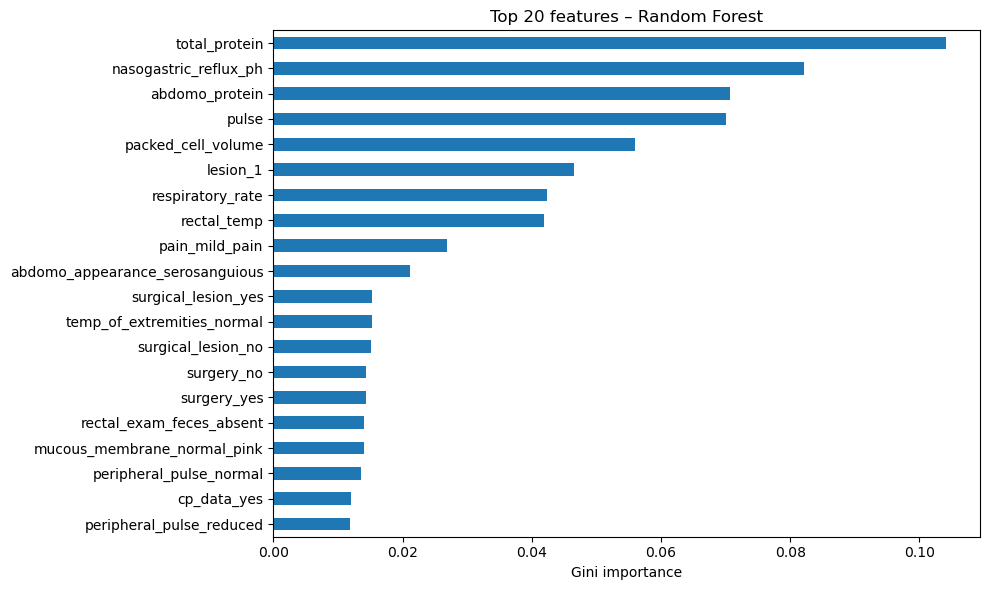

In [17]:
import matplotlib.pyplot as plt

# --- ranking wpływów cech ---
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10,6))
importances.head(20).plot(kind='barh')        # top-20 cech
plt.gca().invert_yaxis()
plt.title("Top 20 features – Random Forest")
plt.xlabel("Gini importance")
plt.tight_layout()
plt.show()

---

In [10]:
# --- uczenie na całym zbiorze treningowym ---
rf.fit(X, y)

# --- przewidywanie dla testu ---
test_preds = rf.predict(test)

# --- zapis pliku submission ---
submission = pd.read_csv('sample_submission.csv')
submission['outcome'] = test_preds
submission.to_csv('submission.csv', index=False)
print("submission.csv created")

submission.csv created


---